In [74]:
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
# json_square 폴더 내 모든 JSON 파일 경로 가져오기
json_files = glob.glob('json/X_train/*.json')

# JSON 파일 데이터를 저장할 리스트
data_list = []

# 각 JSON 파일을 열고 데이터를 불러오기
for file in json_files:
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        data_list.append(data)

###################################################################
def extract_polygon_center_crop_as_array(json_file_path, image_file_path, crop_size=(300, 300)):
    """
    폴리곤 내부 이미지를 추출하고 중심을 기준으로 crop_size로 자른 후, numpy 배열로 반환합니다.

    Parameters:
    - json_file_path (str): JSON 파일 경로
    - image_file_path (str): 이미지 파일 경로
    - crop_size (tuple): 자를 이미지의 크기 (width, height)

    Returns:
    - np.ndarray: 자른 이미지의 numpy 배열
    """
    # JSON 파일에서 폴리곤 좌표 읽기
    with open(json_file_path, 'r') as f:
        data = json.load(f)
        polygon_points = data['shapes'][0]['points']  # 폴리곤 좌표

    # 이미지 불러오기
    image = Image.open(image_file_path).convert("RGB")

    # 폴리곤 마스크 생성
    mask = Image.new("L", image.size, 0)
    draw = ImageDraw.Draw(mask)
    polygon_points = [(int(point[0]), int(point[1])) for point in polygon_points]  # 좌표 정수 변환
    draw.polygon(polygon_points, fill=255)

    # 마스크 적용하여 폴리곤 내부 이미지 추출
    masked_image = Image.composite(image, Image.new("RGB", image.size), mask)

    # 폴리곤 중심 계산
    polygon_array = np.array(polygon_points)
    center_x = int(np.mean(polygon_array[:, 0]))
    center_y = int(np.mean(polygon_array[:, 1]))

    # 중앙 기준으로 잘라낼 좌표 계산
    left = max(0, center_x - crop_size[0] // 2)
    upper = max(0, center_y - crop_size[1] // 2)
    right = min(masked_image.size[0], center_x + crop_size[0] // 2)
    lower = min(masked_image.size[1], center_y + crop_size[1] // 2)

    # 이미지 자르기
    cropped_image = masked_image.crop((left, upper, right, lower))
    #cropped_array = np.expand_dims(cropped_image, axis=2)

    # numpy 배열로 변환 후 반환
    return np.array(cropped_image) / 255

# 사용 예시
json_file_path = 'json/X_train/' + data_list[0]['shapes'][0]['label'] + '.json'
image_file_path = '../data/X_train/' + data_list[0]['shapes'][0]['label'] + '.tif'
cropped_image_array = extract_polygon_center_crop_as_array(json_file_path, image_file_path, crop_size=(100, 100))

print(cropped_image_array.shape)  # 출력 형태 예시
#plt.imshow(cropped_image_array)
####################################################################################
img = []
for i in range(len(data_list)):
    json_file_path = 'json/X_train/' + data_list[i]['shapes'][0]['label'] + '.json'
    image_file_path = '../data/X_train/' + data_list[i]['shapes'][0]['label'] + '.tif'
    cropped_image_array = extract_polygon_center_crop_as_array(json_file_path, image_file_path, crop_size=(100, 100))
    img.append(cropped_image_array)

a = [data_list[i]['imagePath']for i in range(len(data_list))]


b=[[a[i],img[i]] for i in range(len(img))]
b.sort(key=lambda x: x[0])
df = pd.DataFrame(b)

def convert_to_batches(df, batch_size=5, img_shape=(100, 100)):
    """
    데이터프레임의 이미지 데이터를 5개씩 묶어 (N, 5, 100, 100) 형태로 변환합니다.
    
    Parameters:
    - df: DataFrame, 이미지 데이터가 포함된 데이터프레임
    - batch_size: int, 묶을 이미지 개수 (기본값 5)
    - img_shape: tuple, 각 이미지의 모양 (기본값 (100, 100))
    
    Returns:
    - np.ndarray: (N, batch_size, 100, 100) 형태의 배열
    """
    img_batches = []
    for i in range(0, len(df), batch_size):
        # 이미지 5개씩 가져와서 리스트에 추가
        batch = [df.iloc[i:(i+batch_size), -1:].values[j][0] for j in range(batch_size) if i + j < len(df)]
        
        # 5개가 되지 않으면 패스 (끝 부분 처리)
        if len(batch) < batch_size:
            break
        
        # (5, 100, 100)으로 스택
        batch = np.stack(batch, axis=0)
        img_batches.append(batch)
    
    # (N, 5, 100, 100) 형태로 변환
    #img_batches = np.stack(img_batches, axis=2)
    
    return img_batches

# 예시 사용
img_batches = convert_to_batches(df, batch_size=5, img_shape=(100, 100))
print(img_batches[0].shape)

#######################################
no_img=pd.read_csv("../data/no_image_train_X.csv").iloc[:,1:]

df__= pd.DataFrame([img_batches]).T


name=[]
for j in range(331):
    asdf=np.array([b[i][0] for i in range(len(b))]).reshape(-1,5)[:,0].tolist()[j][8:-6]
    name.append(asdf)
idx = np.array([name[i] for i in range(331)]).astype(int)
y = pd.read_csv("../data/no_image_train_y.csv").iloc[:,1:].T[idx].T.reset_index().iloc[:,1:]

no_img.T[idx].T.reset_index().iloc[:,1:]



fin_df = pd.concat([pd.DataFrame(name),df__,no_img.T[idx].T.reset_index().iloc[:,1:],y],axis=1)
true_df = fin_df[fin_df.iloc[:,-1] == 1]
false_df = fin_df[fin_df.iloc[:,-1] == 0]
dddf = pd.concat([false_df,true_df,true_df,true_df,true_df,true_df,true_df,true_df,true_df,true_df])
dddf=dddf.reset_index().iloc[:,1:]

###############################################################################################

(100, 100, 3)
(5, 100, 100, 3)


In [92]:
# JSON 파일 경로 및 이미지 파일 경로에서 'train'을 'test'로 변경
json_files = glob.glob('json/X_test/*.json')  # 폴더명을 X_test로 변경

# JSON 파일 데이터를 저장할 리스트
data_list = []

# 각 JSON 파일을 열고 데이터를 불러오기
for file in json_files:
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        data_list.append(data)

# 이미지 경로 및 데이터 추출 함수 사용
img = []
for i in range(len(data_list)):
    json_file_path = 'json/X_test/' + data_list[i]['shapes'][0]['label'] + '.json'  # X_test로 변경
    image_file_path = '../data/X_test/' + data_list[i]['shapes'][0]['label'] + '.tif'  # X_test로 변경
    cropped_image_array = extract_polygon_center_crop_as_array(json_file_path, image_file_path, crop_size=(100, 100))
    img.append(cropped_image_array)
print(cropped_image_array.shape)  # 출력 형태 예시

a = [data_list[i]['imagePath'] for i in range(len(data_list))]

# DataFrame 생성 및 정렬 후 'train'을 'test'로 변환
b = [[a[i], img[i]] for i in range(len(img))]
b.sort(key=lambda x: x[0])
df = pd.DataFrame(b)

img_batches = convert_to_batches(df, batch_size=5, img_shape=(100, 100))
print(img_batches[0].shape)
# 새로운 'no_image_test_X.csv' 파일을 불러오기
no_img = pd.read_csv("../data/no_image_test_X.csv").iloc[:, 1:]
df__= pd.DataFrame([img_batches]).T

# 업데이트된 인덱스 정보 반영
name = []
ccc = 123
for j in range(ccc):
    asdf = np.array([b[i][0] for i in range(len(b))]).reshape(-1, 5)[:, 0].tolist()[j][7:-6]
    name.append(asdf)
idx = np.array([name[i] for i in range(ccc)]).astype(int)

# y 데이터 및 no_img 데이터에서 'train'을 'test'로 변경
y = pd.read_csv("../data/no_image_test_y.csv").iloc[:, 1:].T[idx].T.reset_index().iloc[:, 1:]
no_img_test = no_img.T[idx].T.reset_index().iloc[:, 1:]

# 최종 DataFrame 결합
fin_test_df = pd.concat([pd.DataFrame(name), df__, no_img_test, y], axis=1)

# True와 False 데이터프레임 나누기 및 클래스 불균형 조정
#true_df = fin_df[fin_df.iloc[:, -1] == 1]
#false_df = fin_df[fin_df.iloc[:, -1] == 0]
#dddf = pd.concat([false_df, true_df, true_df, true_df, true_df, true_df, true_df, true_df, true_df, true_df])
#dddf = dddf.reset_index().iloc[:, 1:]


(100, 100, 3)
(5, 100, 100, 3)


---

In [76]:
arrrr = [dddf.iloc[:,1].values.tolist()[i] for i in range(len(dddf))]
fixed_arrays = [arr if arr.shape == (5, 100, 100, 3) else np.resize(arr, (5, 100, 100, 3)) for arr in arrrr]
stacked_array = np.stack(fixed_arrays)
train_X = stacked_array[:,3,:,:,:]
train_y = dddf.iloc[:,-1]

In [98]:
arrrr1 = [fin_test_df.iloc[:,1].values.tolist()[i] for i in range(len(fin_test_df))]
fixed_arrays1 = [arr if arr.shape == (5, 100, 100, 3) else np.resize(arr, (5, 100, 100, 3)) for arr in arrrr1]
stacked_array1 = np.stack(fixed_arrays1)
test_X = stacked_array1[:,3,:,:,:]
test_y = fin_test_df.iloc[:,-1]

In [123]:
noimg_train_X= dddf.iloc[:,2:-1]
noimg_test_X=fin_test_df.iloc[:,2:-1]

---
# model1

In [50]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import EarlyStopping
# 모델 초기화
def model_base():
    K.clear_session()
    model = Sequential()
    
    # 1번째 합성곱 층
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))  # 흑백 이미지
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 2번째 합성곱 층
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 3번째 합성곱 층
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten
    model.add(Flatten())
    
    # Dense 층
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    # 출력 레이어
    model.add(Dense(1, activation='sigmoid'))  # 이진 분류
    
    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 모델 요약 출력
model1 = model_base()
model1.summary()

2024-11-05 01:22:16.490420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-05 01:22:16.563210: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-05 01:22:16.563228: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-11-05 01:22:16.934175: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

2024-11-05 01:22:18.062428: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-05 01:22:18.062465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ymlee2-desktop): /proc/driver/nvidia/version does not exist
2024-11-05 01:22:18.063112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [52]:
esp = EarlyStopping(monitor = 'val_loss',patience = 5 , restore_best_weights=True)
history = model1.fit(train_X,train_y,epochs=30,batch_size=16,validation_split=0.3,verbose=1,callbacks=esp)

Epoch 1/30
27/27 [==============================] - 2s 42ms/step - loss: 0.5767 - accuracy: 0.7370 - val_loss: 1.2030 - val_accuracy: 0.3591
Epoch 2/30
27/27 [==============================] - 1s 39ms/step - loss: 0.5079 - accuracy: 0.7678 - val_loss: 0.8824 - val_accuracy: 0.4696
Epoch 3/30
27/27 [==============================] - 1s 38ms/step - loss: 0.4674 - accuracy: 0.7796 - val_loss: 0.8672 - val_accuracy: 0.4420
Epoch 4/30
27/27 [==============================] - 1s 39ms/step - loss: 0.4240 - accuracy: 0.8033 - val_loss: 0.5831 - val_accuracy: 0.6133
Epoch 5/30
27/27 [==============================] - 1s 39ms/step - loss: 0.3711 - accuracy: 0.8341 - val_loss: 0.6497 - val_accuracy: 0.5856
Epoch 6/30
27/27 [==============================] - 1s 37ms/step - loss: 0.2867 - accuracy: 0.8673 - val_loss: 0.3466 - val_accuracy: 0.8453
Epoch 7/30
27/27 [==============================] - 1s 38ms/step - loss: 0.2650 - accuracy: 0.8886 - val_loss: 0.3981 - val_accuracy: 0.8232
Epoch 8/30
27

In [171]:
model1.evaluate(test_X,test_y)

4/4 [==============================] - 0s 16ms/step - loss: 0.9955 - accuracy: 0.8618


[0.9954841136932373, 0.8617886304855347]

4/4 [==============================] - 0s 16ms/step


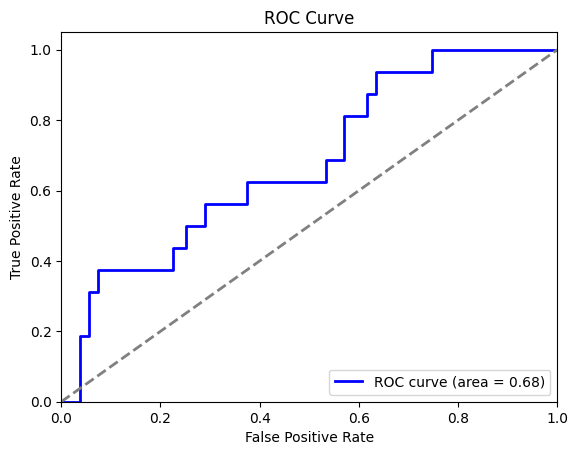

In [172]:
pred=model1.predict(test_X)

from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds = roc_curve(test_y, pred)

# AUC 계산
roc_auc = auc(fpr, tpr)

# ROC 커브 그리기
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

---
# model2

In [151]:
def create_model2():
    # 이미지 입력 처리
    image_input = layers.Input(shape=(100, 100, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dropout(0.4)(x)
    image_output = x

    # 변수 입력 처리 (SELU 적용)
    variables_input = layers.Input(shape=(40,))
    y = layers.Dense(64, activation='selu')(variables_input)  # SELU 활성화 함수 사용
    y = layers.Dropout(0.2)(y)
    y = layers.Dense(128, activation='selu')(variables_input)  # SELU 활성화 함수 사용
    y = layers.Dropout(0.2)(y)

    # 입력 병합
    merged = layers.multiply([image_output, y])
    z = layers.Dense(32, activation='relu')(merged)  # 추가 Dense 레이어
    z = layers.Dropout(0.3)(z)  # 병합 후 추가 드롭아웃
    z = layers.Dense(16, activation='relu')(z) 
    z = layers.Dropout(0.3)(z)
    # 출력 레이어
    output = layers.Dense(1, activation='sigmoid')(z)
    model = models.Model(inputs=[image_input, variables_input], outputs=output)

    # 모델 컴파일
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# 모델 생성
model2 = create_model2()


In [152]:
history = model2.fit([train_X,noimg_train_X],train_y,epochs=50,batch_size=16,validation_split= 0.3,verbose=1,callbacks=esp)

Epoch 1/50
27/27 [==============================] - 3s 69ms/step - loss: 0.5819 - accuracy: 0.6682 - val_loss: 1.0308 - val_accuracy: 0.3536
Epoch 2/50
27/27 [==============================] - 2s 65ms/step - loss: 0.5176 - accuracy: 0.7701 - val_loss: 0.6528 - val_accuracy: 0.6409
Epoch 3/50
27/27 [==============================] - 2s 65ms/step - loss: 0.4666 - accuracy: 0.7725 - val_loss: 0.5356 - val_accuracy: 0.7680
Epoch 4/50
27/27 [==============================] - 2s 65ms/step - loss: 0.3665 - accuracy: 0.8270 - val_loss: 0.4981 - val_accuracy: 0.7956
Epoch 5/50
27/27 [==============================] - 2s 66ms/step - loss: 0.3911 - accuracy: 0.8152 - val_loss: 0.3999 - val_accuracy: 0.8564
Epoch 6/50
27/27 [==============================] - 2s 66ms/step - loss: 0.3239 - accuracy: 0.8649 - val_loss: 0.3896 - val_accuracy: 0.8840
Epoch 7/50
27/27 [==============================] - 2s 66ms/step - loss: 0.3013 - accuracy: 0.8744 - val_loss: 0.2085 - val_accuracy: 0.9669
Epoch 8/50
27

In [157]:
model2.evaluate([test_X,noimg_test_X],test_y)

4/4 [==============================] - 0s 15ms/step - loss: 0.4437 - accuracy: 0.9512


[0.44367271661758423, 0.9512194991111755]

4/4 [==============================] - 0s 16ms/step


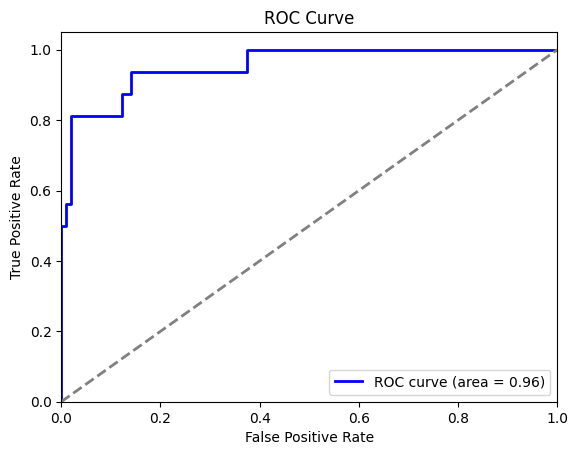

In [153]:
pred=model2.predict([test_X,noimg_test_X])

from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds = roc_curve(test_y, pred)

# AUC 계산
roc_auc = auc(fpr, tpr)

# ROC 커브 그리기
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [183]:
train_Xf= np.concatenate([train_X,test_X])
train_yf = np.concatenate([train_y,test_y])
noimg_train_Xf = np.concatenate([noimg_train_X,noimg_train_y])

In [187]:
from sklearn.model_selection import KFold
from tensorflow.keras.metrics import AUC
def create_model2():
    # 이미지 입력 처리
    image_input = layers.Input(shape=(100, 100, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    image_output = x

    # 변수 입력 처리 (SELU 적용)
    variables_input = layers.Input(shape=(40,))
    y = layers.Dense(64, activation='selu')(variables_input)
    y = layers.Dropout(0.2)(y)
    y = layers.Dense(128, activation='selu')(y)
    y = layers.Dropout(0.2)(y)

    # 입력 병합
    merged = layers.multiply([image_output, y])
    z = layers.Dense(32, activation='relu')(merged)
    z = layers.Dropout(0.3)(z)
    z = layers.Dense(16, activation='relu')(z) 
    z = layers.Dropout(0.3)(z)

    # 출력 레이어
    output = layers.Dense(1, activation='sigmoid')(z)
    model = models.Model(inputs=[image_input, variables_input], outputs=output)

    # 모델 컴파일
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='binary_crossentropy',  metrics=['accuracy', AUC(name='auc')])

    return model

# KFold 설정
k = 5  # K의 값 설정
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_accuracies = []
test_accuracies = []
fold_aucs = []
test_aucs = []
for fold, (train_index, val_index) in enumerate(kf.split(train_Xf), 1):
    print(f"\nFold {fold} 시작:")
    K.clear_session()
    # 훈련 및 검증 데이터 분리
    X_image_train, X_image_val = train_Xf[train_index], train_Xf[val_index]
    X_variables_train, X_variables_val = noimg_train_Xf[train_index],noimg_train_Xf[val_index]
    y_train, y_val = train_yf[train_index], train_yf[val_index]
    
    # 각 폴드에서 새로운 모델 생성
    model = create_model2()
    
    # 모델 학습
    esp = EarlyStopping(monitor = 'val_loss',patience = 5 , restore_best_weights=True)
    model.fit([X_image_train, X_variables_train], y_train, validation_split= 0.3, epochs=50, batch_size=16, verbose=0, callbacks=esp)
    
    val_loss, val_accuracy, val_auc = model.evaluate([X_image_val, X_variables_val], y_val, verbose=0)
    #test_loss, test_accuracy, test_auc = model.evaluate([test_X, noimg_test_X], test_y, verbose=0)
    
    fold_accuracies.append(val_accuracy)
    #test_accuracies.append(test_accuracy)
    fold_aucs.append(val_auc)
    #test_aucs.append(test_auc)
    
    print(f"Fold {fold} val_accuracy: {val_accuracy}, val_auc: {val_auc}")
    #print(f"Fold {fold} test_accuracy: {test_accuracy}, test_auc: {test_auc}")
    del model

print(f"\nval_accuracy mean across {k} folds: {np.mean(fold_accuracies)}")
print(f"val_auc mean across {k} folds: {np.mean(fold_aucs)}")
#print(f"\ntest_accuracy mean across {k} folds: {np.mean(test_accuracies)}")
#print(f"test_auc mean across {k} folds: {np.mean(test_aucs)}")



Fold 1 시작:
Fold 1 val_accuracy: 0.9520547986030579, val_auc: 0.9976958632469177

Fold 2 시작:
Fold 2 val_accuracy: 0.9448275566101074, val_auc: 0.9791906476020813

Fold 3 시작:
Fold 3 val_accuracy: 0.9448275566101074, val_auc: 0.9841507077217102

Fold 4 시작:
Fold 4 val_accuracy: 0.9586206674575806, val_auc: 0.9722222089767456

Fold 5 시작:
Fold 5 val_accuracy: 0.9655172228813171, val_auc: 0.984953761100769

val_accuracy mean across 5 folds: 0.9531695604324341
val_auc mean across 5 folds: 0.9836426377296448


---
# model3

In [128]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, multiply, Dense, Dropout, Flatten, GaussianNoise, AlphaDropout, ReLU, Conv2D, BatchNormalization
from keras.activations import selu


def CustomNet():
    image_input=Input((100,100,3),name='image_input')
    clinic_input=Input((40,),name='clinical_input')

################ clinical side

    co1=Dense(64,activation='selu',kernel_initializer='lecun_normal',bias_initializer='lecun_normal')(clinic_input)
    co1=AlphaDropout(0.1)(co1)

    co2=Dense(64,activation='selu',kernel_initializer='lecun_normal',bias_initializer='lecun_normal')(co1)
    co2=AlphaDropout(0.1)(co2)

    co3=Dense(128,activation='selu',kernel_initializer='lecun_normal',bias_initializer='lecun_normal')(co2)
    co3=AlphaDropout(0.1)(co3)

    co4=Dense(256,activation='selu',kernel_initializer='lecun_normal',bias_initializer='lecun_normal')(co3)
    co4=AlphaDropout(0.1)(co4)

    co5=Dense(256,activation='selu',kernel_initializer='lecun_normal',bias_initializer='lecun_normal')(co4)
    co5=AlphaDropout(0.1)(co5)

############### image side

    output=Conv2D(64, (3, 3), padding='same',use_bias=False,kernel_initializer=keras.initializers.he_normal(seed=122))(image_input)
    output=BatchNormalization(axis=-1,center=False)(output)
    output=ReLU()(output)

    output=Conv2D(64, (3, 3), strides=(2,2), padding='same',use_bias=False,kernel_initializer=keras.initializers.he_normal(seed=123))(output)
    output=multiply([output,co1])
    output=BatchNormalization(axis=-1,center=False)(output)
    output=ReLU()(output)

##############
    output=Conv2D(64, (3, 3), padding='same',use_bias=False,kernel_initializer=keras.initializers.he_normal(seed=124))(output)
    output=BatchNormalization(axis=-1,center=False)(output)
    output=ReLU()(output)

    output=Conv2D(64, (3, 3), strides=(2,2),padding='same',use_bias=False,kernel_initializer=keras.initializers.he_normal(seed=125))(output)
    output=multiply([output,co2])
    output=BatchNormalization(axis=-1,center=False)(output)
    output=ReLU()(output)

##############
    output=Conv2D(128, (3,3), padding='same',use_bias=False,kernel_initializer=keras.initializers.he_normal(seed=126))(output)
    output=BatchNormalization(axis=-1,center=False)(output)
    output=ReLU()(output)

    output=Conv2D(128, (3, 3), strides=(2,2), padding='same',use_bias=False,kernel_initializer=keras.initializers.he_normal(seed=127))(output)
    output=multiply([output,co3])
    output=BatchNormalization(axis=-1,center=False)(output)
    output=ReLU()(output)
############
    output=Conv2D(256, (3, 3), padding='same',use_bias=False,kernel_initializer=keras.initializers.he_normal(seed=129))(output)
    output=BatchNormalization(axis=-1,center=False)(output)
    output=ReLU()(output)

    output=Conv2D(256, (3, 3), strides=(2,2), padding='same',use_bias=False,kernel_initializer=keras.initializers.he_normal(seed=130))(output)
    output=multiply([output,co4])
    output=BatchNormalization(axis=-1,center=False)(output)
    output=ReLU()(output)
#############
    output=Conv2D(256, (3, 3), padding='same',use_bias=False,kernel_initializer=keras.initializers.he_normal(seed=132))(output)
    output=BatchNormalization(axis=-1,center=False)(output)
    output=ReLU()(output)

    output=Conv2D(256, (3, 3), strides=(2,2), padding='same',use_bias=False,kernel_initializer=keras.initializers.he_normal(seed=133))(output)
    output=multiply([output,co5])
    output=BatchNormalization(axis=-1,center=False)(output)
    output=ReLU()(output)
##############

    output=Flatten()(output)
    output=Dense(4096)(output)
    output=ReLU()(output)


    output=Dense(512)(output)
    output=ReLU()(output)
    output=Dense(64)(output)
    output=ReLU()(output)


    output=Dense(1,activation='sigmoid')(output)
    #output=Activation('softmax')(output)

    model=Model(inputs=[image_input,clinic_input],outputs=output)
    optimizer = Adam(learning_rate=0.00005)
    model.compile(optimizer=optimizer , loss='binary_crossentropy', metrics=['accuracy'])
    return model 

In [129]:
model3= CustomNet()
#esp = EarlyStopping(monitor = 'val_loss',patience = 10 , restore_best_weights=True)
history =model3.fit([train_X,noimg_train_X],train_y,epochs=50,batch_size=16,validation_split=0.3,verbose=1,callbacks=[esp])

Epoch 1/50
27/27 [==============================] - 9s 270ms/step - loss: 0.6120 - accuracy: 0.7204 - val_loss: 0.7037 - val_accuracy: 0.1492
Epoch 2/50
27/27 [==============================] - 7s 264ms/step - loss: 0.6155 - accuracy: 0.7038 - val_loss: 0.6973 - val_accuracy: 0.5083
Epoch 3/50
27/27 [==============================] - 7s 265ms/step - loss: 0.5800 - accuracy: 0.7251 - val_loss: 0.7914 - val_accuracy: 0.0608
Epoch 4/50
27/27 [==============================] - 7s 262ms/step - loss: 0.5643 - accuracy: 0.7322 - val_loss: 0.7376 - val_accuracy: 0.4254
Epoch 5/50
27/27 [==============================] - 7s 263ms/step - loss: 0.5730 - accuracy: 0.7299 - val_loss: 0.7683 - val_accuracy: 0.3039
Epoch 6/50
27/27 [==============================] - 7s 259ms/step - loss: 0.6036 - accuracy: 0.6991 - val_loss: 0.6698 - val_accuracy: 0.5414
Epoch 7/50
27/27 [==============================] - 7s 260ms/step - loss: 0.5520 - accuracy: 0.7299 - val_loss: 0.8803 - val_accuracy: 0.1602
Epoch 

In [169]:
model3.evaluate([test_X,noimg_test_X],test_y)

4/4 [==============================] - 0s 55ms/step - loss: 0.5399 - accuracy: 0.8374


[0.5399264693260193, 0.8373983502388]

4/4 [==============================] - 0s 60ms/step


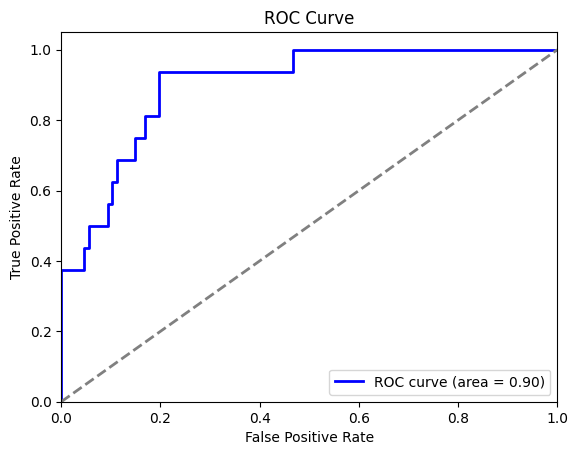

In [130]:
pred=model3.predict([test_X,noimg_test_X])

from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds = roc_curve(test_y, pred)

# AUC 계산
roc_auc = auc(fpr, tpr)

# ROC 커브 그리기
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()